# Initialize

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import nbimporter
import inCITE_tools as ict
import statsmodels.stats as sms
import scvelo as scv
scv.set_figure_params()

run_folder = 'p65_inCITE'
target_dir = 'seq_data/%s' %run_folder

sc.settings.figdir = './analyses/%s' %run_folder
if not os.path.isdir(sc.settings.figdir): os.makedirs(sc.settings.figdir)
sc.settings.verbosity = 3            
sc.logging.print_versions()

processed_file = './write/p65_inCITE.h5ad'
adata = sc.read(processed_file)

antibodies = ['p65']
adata.obs['annot'] = adata.obs['assignment']


/home/jupyter-user/.local/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Importing Jupyter notebook from inCITE_tools.ipynb
-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 7.2.0
anndata             0.7.4
attr                19.1.0
backcall            0.1.0
cffi                1.12.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.6.1
decorator           4.3.0
descartes           NA
get_version         2.1
google              NA
h5py                2.10.0
idna                2.8
igraph              0.8.0
importlib_metadata  1.5.0
inCITE_tools        NA
ipykernel           5.1.2
ipython_genutils    0.2.0
ipywidgets          7.5.1
jedi                0.15.1
joblib              0.11
jsonschema          3.0.2
kiwisolver          1.1.0
legacy_api_wrap     1.2
leidenalg           0.8.0
llvmlite            0.31.0
louvain             0.6.1
matplotlib          3.1.3
mizani              0.7.1
mpl_toolkits        NA
natsort             7.0.1
nbformat            4.4.0
nbimporter          NA
numba             

# Compare RNA and CITE

Slope 0.0387 	 R^2 0.0008 	 pval 0.004098
0.0008227187032691947
0.00409762651116943


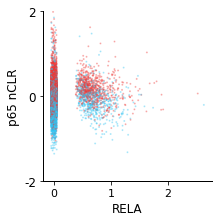

In [2]:
plt.figure(figsize=(3,3))
axes = plt.axes()

gene = 'RELA'
protein = 'p65_nCLR'

axes.set_ylim([-2,2])
axes.set_yticks([-2,0,2])
axes.set_yticklabels(labels=[-2,0,2], fontsize=12)

axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_linewidth(1)
axes.spines['left'].set_linewidth(1)
axes.set_xlabel(xlabel=gene,fontsize=12)
axes.set_ylabel(ylabel='p65 nCLR',fontsize=12)
axes.figure.set_size_inches(3,3)

x_list = ict.get_feat_values(adata, gene)
y_list = ict.get_feat_values(adata, protein)
color_vals = adata.obs['assignment'].map({'NT':'#34c6f4', 'TNFa':'#ef3b39'})

plt.scatter(x_list+np.random.uniform(low=-0.05,high=0.05,size=len(x_list)), y_list,
             s=1,alpha=0.3,color=list(color_vals),axes=axes) # '#78909C'
plt.xlabel(gene,fontsize=12)
plt.ylabel('p65 nCLR',fontsize=12)

Rela_pos = adata[adata[:,gene].layers['counts'].toarray()>0]
X_V,Y_V = ict.get_linear_regression_stats(adata,gene,protein)

plt.savefig('%s/scatter_RELA_p65_nCLR_colored.pdf' %(sc.settings.figdir),
                                                   bbox_inches='tight')

# Linear model: Gene ~ p65 

In [4]:
adata.obs['log_hashtag_counts'] = np.log(adata.obs['hashtag_counts'])
FORMULA = 'Gene ~ p65_nCLR + log_ncounts + G2M_score + S_score + log_hashtag_counts' 
params_nCLR, pvals_nCLR = ict.run_linear_model(adata, FORMULA, 
                                        'HeLa_both_simple_p65_nCLR_model', '', 
                                         model='GLM_NegBin', run_mode='lognorm', 
                                         antibody='p65_nCLR')

sig_nCLR = ict.get_significance_df(pvals_nCLR, method='fdr_bh', alpha=0.01)
sig_nCLR.sum()

Loading prior run result
Ran GLM_NegBin model with lognorm for cluster  and CITE p65_nCLR


Intercept               0
p65_nCLR              142
log_ncounts             0
G2M_score             538
S_score               293
log_hashtag_counts    182
dtype: int64

### top genes + GO analysis

In [5]:
upregulated_significant = pvals_nCLR[(sig_nCLR['p65_nCLR'] & params_nCLR['p65_nCLR']>0)]
top10_p65_genes = upregulated_significant.sort_values(by='p65_nCLR',ascending=True).head(7)
top10_p65_genes

,Intercept,p65_nCLR,log_ncounts,G2M_score,S_score,log_hashtag_counts
CXCL8,0.426881,8.35275e-38,0.426881,0.00432109,0.375902,4.21519e-05
NFKBIA,0.987962,1.85285e-34,0.987962,0.440888,0.86152,0.0286912
CXCL2,0.269936,4.92508e-23,0.269936,0.97161,0.0063283,0.0137725
TNFAIP3,0.312127,1.334e-20,0.312128,0.923569,0.189742,8.37703e-07
IER3,0.995787,3.11766e-19,0.995787,0.816495,0.120197,0.000632636
IL6,0.998128,5.50456e-19,0.998128,2.98653e-07,0.834394,7.8595e-08
JUN,0.490058,8.5847e-19,0.490058,0.941786,0.039721,4.66679e-07


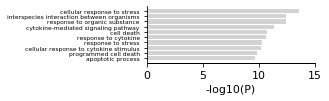

In [6]:
GO_upregulated = ict.parse_GO_query(upregulated_significant.index, 'hsapiens')
GO_upregulated = GO_upregulated.loc[GO_upregulated['source']=='GO:BP']
ict.plot_GO_terms(GO_upregulated.head(10),0.05,'simple_model_NegBin_p65',xlims=[0,15])

## plot top vs. bottom of p65

In [7]:
def sort_idx_by_p65(indices, ad, feat='p65_norm'): 
    # sort cell indices by feature level
    sorted_idx = ad.obs.loc[indices,feat].sort_values(ascending=False).index
    return sorted_idx

def p65_sorted_subset_by_treatment(ad, plot_N=1000, group_order=['TNFa','NT']):
    import random 
    # select equal random subsets of each treatment 
    plot_indices = []
    for treatment in group_order: 
        ad_clust = ad[ad.obs['assignment']==treatment]
        idx = random.sample(set(ad_clust.obs.index), plot_N)
        
        # sort indices based on p65
        sorted_idx = sort_idx_by_p65(idx, ad)
        plot_indices.extend(list(sorted_idx))

    return plot_indices


In [8]:
# identify top 10% and bottom 10% of all cells based on p65 levels
sorted_idx = sort_idx_by_p65(adata.obs.index,adata,'p65_nCLR')
group_len = int(len(sorted_idx)/10)
adata.obs['p65_level'] = 'p65_middle'
adata.obs.loc[sorted_idx[0:group_len],'p65_level'] = 'p65_high'
adata.obs.loc[sorted_idx[-group_len:],'p65_level'] = 'p65_low'
ad_top_bottom = adata[((adata.obs['p65_level']=='p65_high')|(adata.obs['p65_level']=='p65_low'))]


In [9]:
# for the top vs. bottom 10% p65 cells, construct data for plotting 
quintile_sorted_idx = sort_idx_by_p65(ad_top_bottom.obs.index,adata,'p65_nCLR')
ad_top_bottom = ad_top_bottom[quintile_sorted_idx]
plot_p65_level = ad_top_bottom.obs['p65_level']
plot_p65_int = plot_p65_level.map({'p65_high':0,'p65_low':1})
plot_p65_int = plot_p65_int.astype(int).to_frame()
plot_p65_quintile = ad_top_bottom.obs['p65_nCLR'].to_frame()

In [10]:
GENES_TO_PLOT = top10_p65_genes.index
VALUES = 'zscore'
if VALUES=='zscore':
    vals = ad_top_bottom[:,GENES_TO_PLOT].X
#     vals = ad_top_bottom[:,GENES_TO_PLOT].layers['zscore'].toarray()
elif VALUES=='lognorm': 
    vals = ad_top_bottom[:,GENES_TO_PLOT].layers['counts'].toarray()
plot_matrix_quintile = pd.DataFrame(vals, index=ad_top_bottom.obs.index,columns=GENES_TO_PLOT)


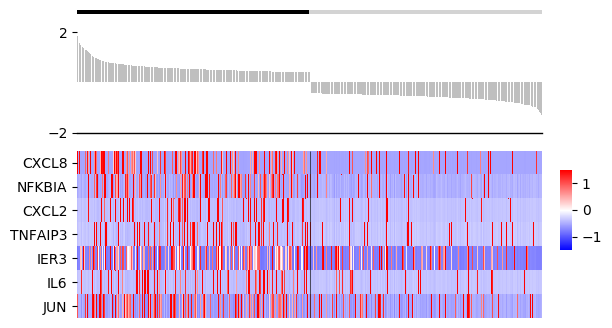

In [11]:
import seaborn as sns
sns.reset_orig()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(6,4), 
                               gridspec_kw={'height_ratios': [0.05, 1.2, 2]})

# subplot 2
sns.heatmap(plot_p65_int.T,
           cmap=['k','#d3d3d3'],
           yticklabels=[], xticklabels=[],
           ax=ax1, cbar=False)

# subplot 1
ax2.bar(height=plot_p65_quintile['p65_nCLR'],
        x=ad_top_bottom.obs.index, 
       color='#bfbfbf')
ax2.set_xticks([])
ax2.set_yticks([-2,2])
ax2.set_ylim([-2,2])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_linewidth(1)
ax2.spines['left'].set_linewidth(False)

# subplot 3
cax = fig.add_axes([.93, .28, .02, .2])
sns.set(font_scale = 0.02)
ax_h = sns.heatmap(plot_matrix_quintile.T,
                 cmap='bwr',
                   vmin=-1.5, vmax=1.5, center=0,
                yticklabels=GENES_TO_PLOT,
                xticklabels=[],
                 ax=ax3,
                cbar_ax=cax)
cbar_kws=dict(ticks=[])
ax_h.vlines([group_len],*ax_h.get_ylim(), color='k',linewidth=0.5)
fig.savefig('%s/heatmap_decile_p65_nCLR_genes.pdf' %(sc.settings.figdir), bbox_inches='tight')

sns.reset_orig()